In [54]:
import pandas as pd
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [2]:
repertoireCourant = os.getcwd()

In [4]:
data = pd.read_csv(os.path.join(os.path.dirname(repertoireCourant), 'QueryResults_2017.csv'))

<H3>Nettoyage de la colonne Tags</H3>

In [5]:
data.head(2)

,CreationDate,ViewCount,Title,Body,Tags
0,2017-01-12 01:57:22,3143,Spring boot project failing with NoSuchMethodE...,"<p>I have a simple Spring Boot project, I have...",<tomcat><spring-boot>
1,2017-01-12 02:42:09,14227,How to display local image in markdown,"<p>I try the following in markdown, but seems ...",<markdown>


In [6]:
"Nombre de question en 2017: {}".format(len(data))

'Nombre de question en 2017: 18997'

In [7]:
def nettoyageTags(chaineCaractere):
    nlleChaineCaractere = chaineCaractere.replace("><", ",")
    nlleChaineCaractere = nlleChaineCaractere.replace("<", "")
    nlleChaineCaractere = nlleChaineCaractere.replace(">", "")
    return nlleChaineCaractere

In [8]:
data["Tags"] = data["Tags"].apply(nettoyageTags)

<H3>Analyse des tags</H3>

In [9]:
#analyse de la fréquence des tags
frequence_tags = {}
for i, row in data.iterrows():
    for tag in row["Tags"].split(","):
        reponse = frequence_tags.get(tag, -1)
        if reponse == -1:
            frequence_tags[tag] = 1
        else:
            frequence_tags[tag] += 1

In [10]:
"Nombre de tags différents: {}".format(len(frequence_tags))

'Nombre de tags différents: 6049'

In [11]:
tags = []
freq = []
for k, v in frequence_tags.items():
    tags.append(k)
    freq.append(v)
df_tags_freq  = pd.DataFrame({"Tag": tags, "freq": freq})

In [12]:
df_tags_freq = df_tags_freq.sort_values('freq', ascending = False)
df_tags_freq['%'] = df_tags_freq['freq'] / df_tags_freq['freq'].sum() * 100
df_tags_freq['%cumule'] = df_tags_freq['%'].cumsum()

Text(0.5, 1.0, 'Listes des 50 tags les plus cités en 2017')

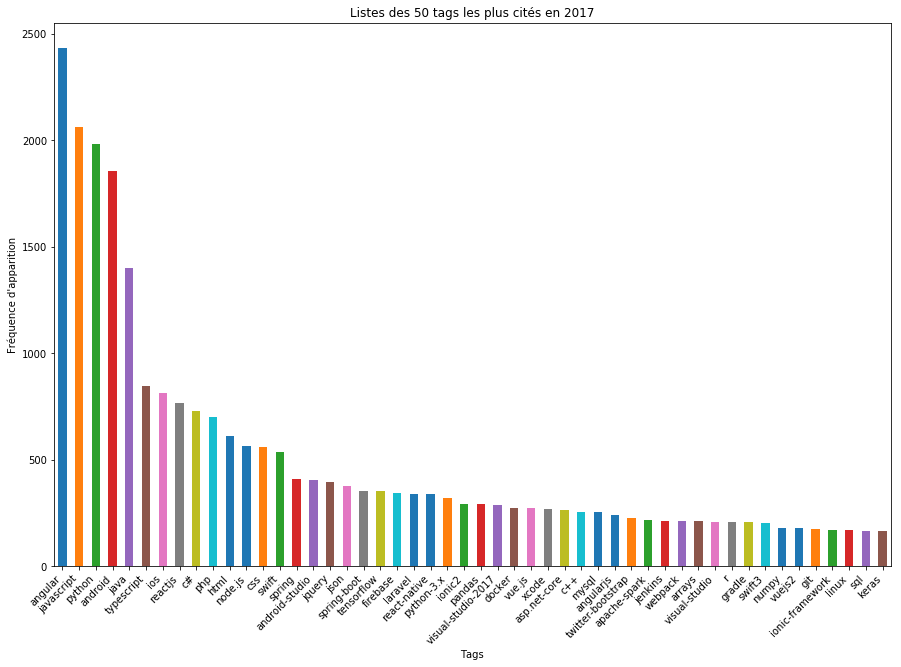

In [13]:
plt.figure(figsize = (15, 10))
df_tags_freq.iloc[:50]['freq'].plot(kind = "bar")
plt.xticks(range(len(df_tags_freq.iloc[:50])), list(df_tags_freq.iloc[:50]['Tag']), rotation = 45, horizontalalignment='right')
plt.xlabel("Tags")
plt.ylabel("Fréquence d'apparition")
plt.title("Listes des 50 tags les plus cités en 2017")

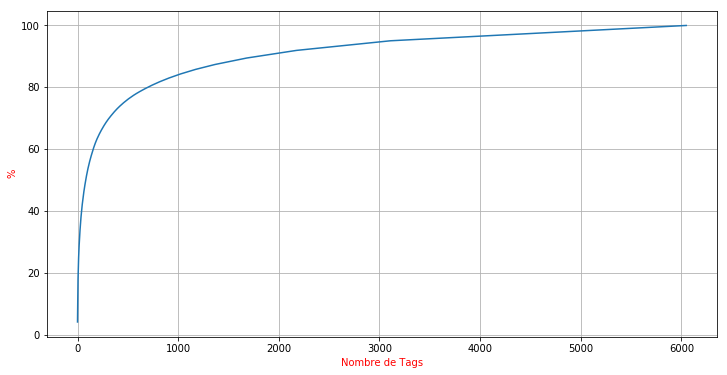

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(df_tags_freq)), df_tags_freq['%cumule'])
plt.xlabel("Nombre de Tags", color = "red")
plt.ylabel("%", color = "red")
plt.grid()

In [15]:
quantile = df_tags_freq['freq'].quantile([i / 100 for i in range(10, 100, 1)])
df_quantile = pd.DataFrame({"freq": list(quantile)}, index = quantile.index)
df_quantile["% apparition"] = df_quantile['freq'] / len(data) * 100

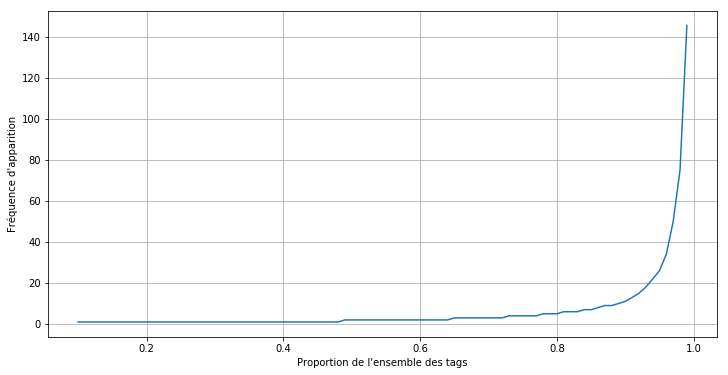

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(df_quantile.index, df_quantile["freq"])
plt.xlabel("Proportion de l'ensemble des tags")
plt.ylabel("Fréquence d'apparition")
plt.grid()

In [17]:
for i, row in df_quantile.iterrows():
    print(i,"\t", row['freq'], "\t", row['% apparition'])

0.1 	 1.0 	 0.005263989050902774
0.11 	 1.0 	 0.005263989050902774
0.12 	 1.0 	 0.005263989050902774
0.13 	 1.0 	 0.005263989050902774
0.14 	 1.0 	 0.005263989050902774
0.15 	 1.0 	 0.005263989050902774
0.16 	 1.0 	 0.005263989050902774
0.17 	 1.0 	 0.005263989050902774
0.18 	 1.0 	 0.005263989050902774
0.19 	 1.0 	 0.005263989050902774
0.2 	 1.0 	 0.005263989050902774
0.21 	 1.0 	 0.005263989050902774
0.22 	 1.0 	 0.005263989050902774
0.23 	 1.0 	 0.005263989050902774
0.24 	 1.0 	 0.005263989050902774
0.25 	 1.0 	 0.005263989050902774
0.26 	 1.0 	 0.005263989050902774
0.27 	 1.0 	 0.005263989050902774
0.28 	 1.0 	 0.005263989050902774
0.29 	 1.0 	 0.005263989050902774
0.3 	 1.0 	 0.005263989050902774
0.31 	 1.0 	 0.005263989050902774
0.32 	 1.0 	 0.005263989050902774
0.33 	 1.0 	 0.005263989050902774
0.34 	 1.0 	 0.005263989050902774
0.35 	 1.0 	 0.005263989050902774
0.36 	 1.0 	 0.005263989050902774
0.37 	 1.0 	 0.005263989050902774
0.38 	 1.0 	 0.005263989050902774
0.39 	 1.0 	 0.00

On constate qu'une très forte proportion des tags apparaissent très peu au regard du nombre de question:
90 % des tags (5444) apparaisent moins de 11 fois sur une base de donnée comportant 18 997 questions
--> Supression des tags figurant moins de 11 fois: si la question n'a plus de tags après suppression alors la question est supprimée

In [18]:
def tagsCleaned(tags, seuil):
    tags2 = []
    for tag in tags.split(","):
        if frequence_tags[tag] >= seuil:
            tags2.append(tag)
    if len(tags2) > 1:
        return ",".join(tags2)
    else:
        return np.nan

In [19]:
data['Tags cleaned'] = data['Tags'].apply(lambda x: tagsCleaned(x, 11))

In [20]:
#Nombre de question restante
"{} % de la base de donnée est conservée après nettoyage des Tags".format(round(len(data[data["Tags cleaned"].notnull()]) / len(data) * 100), 2)

'79 % de la base de donnée est conservée après nettoyage des Tags'

<H3>Analyse du corps des questions</H3>

In [21]:
#Proportion du code versus la question
listeNbreCaracteresBody = []
listeNbreCaracteresCode = []
for i, row in data.iterrows():
    soup = BeautifulSoup(row['Body'])
    codes = soup.find_all("code")
    nbrCarBody = len(row['Body'])
    nbrCarCode = 0
    for code in codes:
        nbrCarCode += len(code.text)
    listeNbreCaracteresBody.append(nbrCarBody)
    listeNbreCaracteresCode.append(nbrCarCode)

In [22]:
statNbreCaract = pd.DataFrame(data = {"nbre caracteres Body": listeNbreCaracteresBody, "nbre caracteres code": listeNbreCaracteresCode}, index = data.index)

In [23]:
statNbreCaract['Proportion'] = round((statNbreCaract['nbre caracteres code'] / statNbreCaract['nbre caracteres Body']) * 100, 2)

In [24]:
statNbreCaract.describe()

,nbre caracteres Body,nbre caracteres code,Proportion
count,18997.000000,18997.000000,18997.000000
mean,1612.415908,926.353793,37.801398
std,2256.470651,2030.436559,28.644301
min,53.000000,0.000000,0.000000
25%,555.000000,57.000000,10.180000
50%,975.000000,323.000000,37.650000
75%,1795.000000,947.000000,61.440000
max,30033.000000,28824.000000,99.760000


In [25]:
def nettoyage_texte(texte):
    for motif in [r"\n", r'<code>.*?<\/code>', r"<.*?>", r"\r", r"(\w+\/)+[\w+\.]+", r'https?://[\S]+', r"(\w+\.)+\w+", r"\$\w+", r'\b(\w)\1+\b', r"  +", r"\b[0-9]+\b"]:
        while re.search(motif, texte):
            texte = re.sub(motif, " ", texte)
    return texte

In [26]:
data['Title_Body'] = data[["Title", "Body"]].apply(lambda x: nettoyage_texte(x['Title'] + " " + x['Body']), axis = 1)

In [27]:
data['nbre_mot_title_body'] = data['Title_Body'].apply(lambda x: len(x.split()))

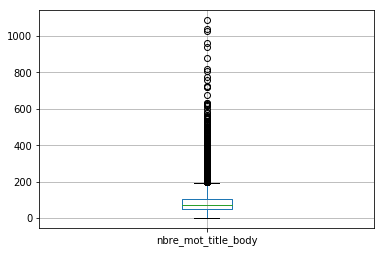

In [28]:
data[['nbre_mot_title_body']].boxplot()

In [29]:
data['nbre_mot_title_body'].quantile([0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

0.001     12.00
0.010     20.00
0.050     30.00
0.250     50.00
0.500     73.00
0.750    108.00
0.950    199.00
0.990    325.04
Name: nbre_mot_title_body, dtype: float64

Text(0, 0.5, 'Nombre de questions')

C:\Users\Lies\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


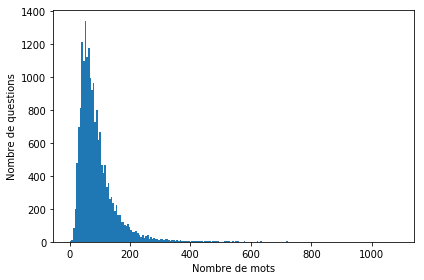

In [30]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(data['nbre_mot_title_body'], bins= 200)
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de questions")

<H3>Tokenization</H3>

In [36]:
from nltk.tokenize import RegexpTokenizer
treebank_wt = nltk.TreebankWordTokenizer()

In [38]:
%%time
texte_token = []
for question in list(data['Title_Body']):
    texte_token.append(treebank_wt.tokenize(question))

Wall time: 5.38 s


<H3>SUPPRESSION DE MOTS CONSTITUE UNIQUEMENT DE CHIFFRE et Mise en minuscule des caractères</H3>

In [51]:
for i, question in enumerate(texte_token):
    q = []
    for mot in question:
        if re.match(r"\d", mot) is None:
            q.append(mot.lower())
    texte_token[i] = q

<h3>SUPPRESSION DES PONCTUATIONS, DES MOTS AVEC _ ET DES MOTS VIDES</h3>

In [46]:
stopwords_english = set(ENGLISH_STOP_WORDS)
", ".join(stopwords_english)

'neither, thus, their, four, whose, from, her, may, seeming, seem, system, over, herein, however, etc, except, myself, amongst, ever, thence, the, some, hers, together, thin, part, several, amoungst, are, therefore, we, whence, always, whatever, take, yourselves, side, there, anywhere, since, or, therein, how, less, afterwards, down, and, into, made, another, i, whom, at, detail, him, un, until, ten, two, between, cannot, anyone, against, not, whenever, sometime, formerly, rather, our, same, become, onto, found, mill, must, been, might, his, move, third, five, during, many, herself, someone, what, least, though, them, hence, when, one, should, sixty, eg, is, could, thick, was, serious, amount, elsewhere, will, up, she, has, no, indeed, even, besides, thereafter, after, so, hasnt, namely, bill, were, often, otherwise, top, me, within, once, about, anyhow, these, twenty, co, every, mine, without, too, in, under, wherein, de, for, it, last, enough, well, re, fill, fire, whether, along, an

In [55]:
%%time
ponctuations = string.punctuation
for i in range(len(texte_token)):
    x = [m for m in texte_token[i] if not (m in ponctuations)]
    expression = re.compile(r"[a-zA-Z0-9]+")
    for j in range(len(x)):
        if expression.search(x[j]):
            x[j] = expression.search(x[j]).group(0)
        else:
            x[j] = ''
    expression = re.compile(r"([a-zA-Z]+_)+[a-zA-Z]*")
    for j in range(len(x)):
        if expression.search(x[j]):
            x[j] = ''
    x = [m for m in x if not (m in stopwords_english)]
    texte_token[i] = [m for m in x if not(len(m) <= 1)]

Wall time: 2.9 s


<h2>LEMMATISATION</H2>

In [57]:
#Normalisation des mots en ne conservant que la racine des mots

In [58]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [59]:
%%time
for i in range(len(texte_token)):
    texte_token[i] = [wnl.lemmatize(m) for m in texte_token[i]]

Wall time: 3.98 s


In [63]:
from nltk.probability import FreqDist
fdist = FreqDist(texte_token)
print(fdist)

TypeError: unhashable type: 'list'

In [61]:
questions = nltk.TextCollection(texte_token)

In [62]:
questions.tf("python")

TypeError: tf() missing 1 required positional argument: 'text'